In [32]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.constants as const

In [33]:
masses = [5.972e24, 5.972e24, 5.972e24] 
m1, m2, m3 = masses

y_0 = [
    -1e8, 0,    # (x1, y1) in meters
     3e7, 0,    # (x2, y2) in meters
     0, 3e7,    # (x3, y3) in meters
     
     1e4, 0,      # (vx1, vy1) in meters per second
     0, 0,      # (vx2, vy2) in meters per second
     0, 0       # (vx3, vy3) in meters per second
]


def compute_acceleration(pos1, pos2, mass2):
    distance_vector = pos2 - pos1
    distance = np.linalg.norm(distance_vector)
    if distance == 0:
        return np.zeros_like(pos1)
    return const.G * mass2 * distance_vector / distance**3


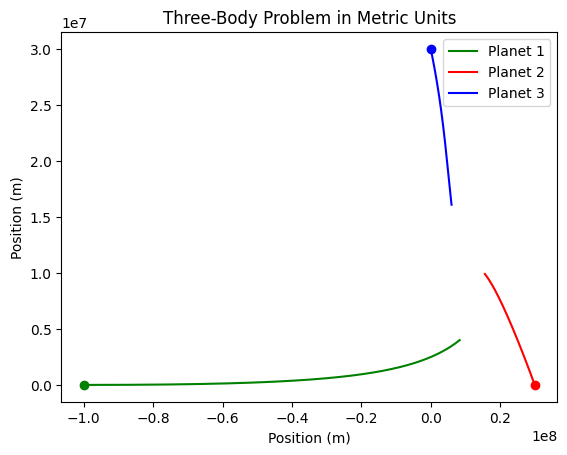

In [42]:
def three_body_problem(t, y):
    dydt = np.zeros_like(y)
    
    pos1 = np.array([y[0], y[1]])
    pos2 = np.array([y[2], y[3]])
    pos3 = np.array([y[4], y[5]])
    
    vel1 = np.array([y[6], y[7]])
    vel2 = np.array([y[8], y[9]])
    vel3 = np.array([y[10], y[11]])
    
    dydt[0:2] = vel1  # dx1/dt, dy1/dt
    dydt[2:4] = vel2  # dx2/dt, dy2/dt
    dydt[4:6] = vel3  # dx3/dt, dy3/dt
    
    acc1 = compute_acceleration(pos1, pos2, m2) + compute_acceleration(pos1, pos3, m3)
    acc2 = compute_acceleration(pos2, pos1, m1) + compute_acceleration(pos2, pos3, m3)
    acc3 = compute_acceleration(pos3, pos1, m1) + compute_acceleration(pos3, pos2, m2)
    
    dydt[6:8] = acc1  # dvx1/dt, dvy1/dt
    dydt[8:10] = acc2  # dvx2/dt, dvy2/dt
    dydt[10:12] = acc3  # dvx3/dt, dvy3/dt
    
    return dydt

N = 10000
T = 1  # Time step in seconds
t = np.linspace(0, N*T, N)

# Solve the system
solution = solve_ivp(
    fun=three_body_problem,
    t_span=[0, N*T],
    y0=y_0,
    t_eval=t,
    rtol=1e-10,
    
    
)# Plotting the orbits
plt.plot(solution.y[0], solution.y[1], '-g', label="Planet 1")  # (x1, y1)
plt.plot(solution.y[2], solution.y[3], '-r', label="Planet 2")  # (x2, y2)
plt.plot(solution.y[4], solution.y[5], '-b', label="Planet 3")  # (x3, y3)
plt.plot(y_0[0], y_0[1], 'o', color='green')
plt.plot(y_0[2], y_0[3], 'o', color='red',)
plt.plot(y_0[4], y_0[5], 'o', color='blue',)
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Three-Body Problem in Metric Units")
plt.show()

In [48]:
print(solution.y.size)

120000
